### MNIST One Pixel Attack

In [1]:
# Tensorflow logging: OFF
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [4]:
# Generic libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Machine learning
import tensorflow as tf
from keras import backend

# CNN layers
from tensorflow.keras.layers import (Conv2D, MaxPooling2D)
from tensorflow.keras.layers import (Dropout, BatchNormalization, Flatten, Dense)
from tensorflow.keras.layers import LeakyReLU

# MNIST dataset
from tensorflow.keras.datasets import mnist

# Optimiziers
from tensorflow.keras.optimizers import Adam

# Others
from tensorflow.keras import Input

print(tf.__version__)

2.14.0


#### Load Dataset & Pre-Processing

In [5]:
# Load MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [6]:
# Define the input shape of the images and the number of classes
num_classes = 10
img_rows, img_cols = 28, 28

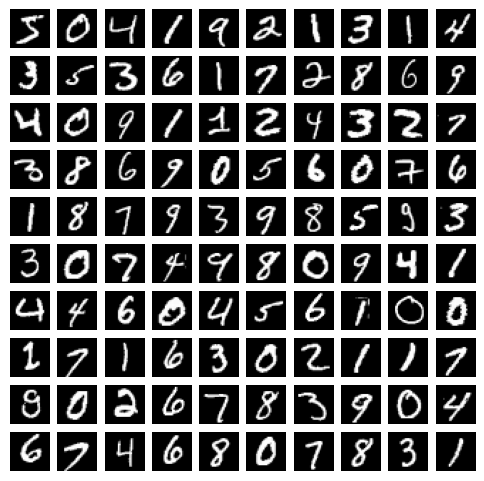

In [7]:
# Show grid of 10x10 images
fig, ax = plt.subplots(10, 10, figsize=(6,6))
for i in range(10):
    for j in range(10):
        ax[i,j].imshow(train_images[i*10+j], cmap='gray')
        ax[i,j].axis('off')
plt.show()

In [8]:
# Normalize the data
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

In [9]:
# Reshape the images to add the mono channel dimension (1)
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)

In [10]:
# Convert class vectors to binary class matrices
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

#### Predictions

In [11]:
# Model name
MODEL_SAVED = "./Models/MNIST_CNN.keras"

# Load the model
model = tf.keras.models.load_model(MODEL_SAVED)

# Get the predictions
predictions = model.predict(test_images)

313/313 [==============================] - 1s 4ms/step


In [12]:
# Print prediction
print(predictions[0])

[5.7622995e-12 5.2644217e-10 1.9288802e-09 1.8686701e-11 5.0521447e-13
 5.3212670e-14 3.3540648e-18 9.9999994e-01 5.1015130e-12 3.9110613e-09]


In [39]:
# Print the predicted class
print(f"Predicted Class: {np.argmax(predictions[0])}")

# Print the confidence
confidences = np.max(predictions, axis=1)
print(f"Confidence: {confidences[i]}")

Predicted Class: 5
Confidence: 0.9999999403953552


In [42]:
# Print the real class
print(f"Actual Class: {np.argmax(test_labels[0])}")

Actual Class: 7


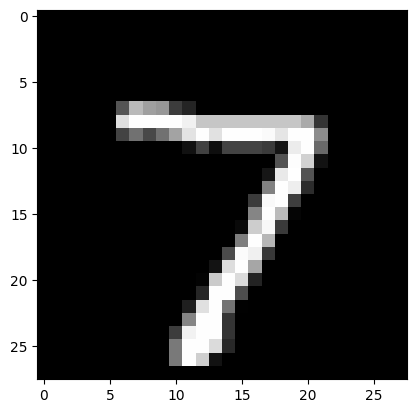

In [15]:
# Print the image
plt.imshow(test_images[0].reshape(28,28), cmap='gray')
plt.show()

#### One Pixel Attack

In [16]:
x_dataset = train_images
y_dataset = train_labels

In [17]:
# Choose the target class for the misclassification
target_class = 7

In [18]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

In [19]:
# Create a function to compute the loss
def get_loss(x, target_class):
    prediction = model(x)
    loss = loss_object(target_class, prediction)
    return loss

# Create a gradient tape to compute gradients
def get_gradients(x, target_class):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = get_loss(x, target_class)
    grads = tape.gradient(loss, x)
    return grads

In [20]:
# Define the attack parameters
num_iterations = 100
epsilon = 0.01

In [21]:
len(x_dataset)

60000

In [23]:
# Perform the One Pixel Attack on the entire dataset
for i in range(len(x_dataset)):
    img = x_dataset[i:i+1] 
    img = tf.convert_to_tensor(img)
    grads = get_gradients(img, target_class)
    img += epsilon * tf.sign(grads)
    x_dataset[i:i+1] = img

In [24]:
# Perform inference on the adversarial dataset
predictions = model.predict(x_dataset)

1875/1875 [==============================] - 8s 4ms/step


In [29]:
# Display the predicted classes and confidences for the entire dataset
predicted_classes = np.argmax(predictions, axis=1)
confidences = np.max(predictions, axis=1)

for i in range(len(predicted_classes)):
    print(f"Sample {i + 1}: Predicted Class - {predicted_classes[i]}, Confidence - {confidences[i]:.2f}")

Sample 1: Predicted Class - 5, Confidence - 1.00
Sample 2: Predicted Class - 0, Confidence - 1.00
Sample 3: Predicted Class - 4, Confidence - 1.00
Sample 4: Predicted Class - 1, Confidence - 1.00
Sample 5: Predicted Class - 9, Confidence - 1.00
Sample 6: Predicted Class - 2, Confidence - 1.00
Sample 7: Predicted Class - 1, Confidence - 1.00
Sample 8: Predicted Class - 3, Confidence - 1.00
Sample 9: Predicted Class - 1, Confidence - 1.00
Sample 10: Predicted Class - 4, Confidence - 1.00
Sample 11: Predicted Class - 3, Confidence - 1.00
Sample 12: Predicted Class - 5, Confidence - 1.00
Sample 13: Predicted Class - 3, Confidence - 1.00
Sample 14: Predicted Class - 6, Confidence - 1.00
Sample 15: Predicted Class - 1, Confidence - 1.00
Sample 16: Predicted Class - 7, Confidence - 1.00
Sample 17: Predicted Class - 2, Confidence - 1.00
Sample 18: Predicted Class - 8, Confidence - 1.00
Sample 19: Predicted Class - 6, Confidence - 1.00
Sample 20: Predicted Class - 9, Confidence - 1.00
Sample 21

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [30]:
# Print prediction
print(predictions[0])

[7.9004499e-16 5.2898859e-16 1.4667031e-16 2.1453090e-04 6.6471572e-18
 9.9978542e-01 5.2472139e-14 6.5799241e-14 2.6663199e-10 6.2393237e-09]


In [38]:
# Print the predicted class
print(f"Predicted Class: {np.argmax(predictions[0])}")

# Print the confidence
confidences = np.max(predictions, axis=1)
print(f"Confidence: {confidences[i]}")

Predicted Class: 5
Confidence: 0.9999999403953552


In [43]:
# Print the real class
print(f"Actual Class: {np.argmax(test_labels[0])}")

Actual Class: 7


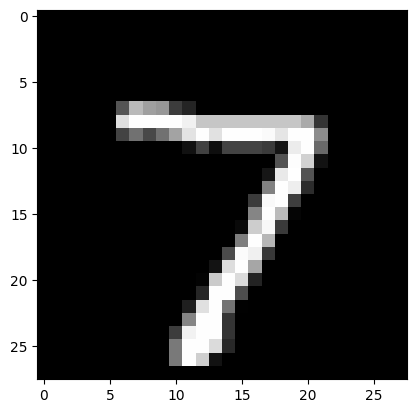

In [33]:
# Print the image
plt.imshow(test_images[0].reshape(28,28), cmap='gray')
plt.show()